# Download data

In [94]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [95]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [96]:
# function for import the data .parquet to pandas dataframe
def import_data(i): # the data have 10 partiton 0 to 9
    file_path = f"data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet"
    df = pd.read_parquet(file_path)
    print(f"import train data part {i}")
    return df

In [97]:
# test/example of the import fuction
# train0 = download_data(0)
train_data = import_data(9) # there are just more data in the train.parquet partition 9

import train data part 9


In [98]:
# import test data 
file_path  = f"data/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet"
test_data = pd.read_parquet(file_path)

In [99]:
# import lag data
file_path  = f"data/jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet"
lag_data = pd.read_parquet(file_path)

# Data Preprocessing

## Data cleaning

In [100]:
# feature selection ## select every feature except 0-4 
all_features_cols = [f"feature_{idx:02d}" for idx in range(79)]

#select target values
target_cols = ["responder_6"]

#select lag values
tag = ["date_id", 'symbol_id']

# select the weight values
weight_cols = ["weight"]


## drop the other responder column

## respons to nan values

In [101]:
# remove the nan values
def replace_nan_with_mean_or_zero(column):
    mean_value = column.mean()
    if pd.notnull(mean_value):
        return column.fillna(mean_value)
    else:
        return column.fillna(0)

# Create training data with lag

In [102]:
#new lag data
lags = train_data[ tag + target_cols]
lags = lags.rename(columns= {'responder_6':'responder_6_lag_1'})

lags.date_id = lags.date_id + 1
lags = lags.groupby(["date_id", "symbol_id"]).last()  # pick up last record of previous date
train_data = train_data.join(lags, on = ['date_id', 'symbol_id'], how = 'left')

all_features_cols= all_features_cols + ['responder_6_lag_1']

In [20]:
# Extract features and target, and add lagged target values
# # comment out the lagged target values if you dont want to use them
# train_data['responder_6_lag_1'] = train_data.groupby(['symbol_id','time_id'])[target_cols].shift(1)
# all_features_cols= all_features_cols + ['responder_6_lag_1']

In [103]:
# Split the data into training and validation sets
train_data = train_data.apply(replace_nan_with_mean_or_zero)
max_date_id = train_data['date_id'].max()
num_val = 10
train_set = train_data[train_data['date_id'] < max_date_id - num_val]
val_set = train_data[train_data['date_id'] >= max_date_id - num_val]

# model

In [104]:
train_set[target_cols].min(), train_set[target_cols].max()

(responder_6   -5.0
 dtype: float32,
 responder_6    5.0
 dtype: float32)

In [105]:
from sklearn.preprocessing import MinMaxScaler

ScaleX = MinMaxScaler(feature_range=(-1,1)).fit(train_set[all_features_cols])
ScaleY = MinMaxScaler(feature_range=(-1,1)).fit(train_set[target_cols])
X_train = ScaleX.transform(train_set[all_features_cols])
y_train = ScaleY.transform(train_set[target_cols])
X_val = ScaleX.transform(val_set[all_features_cols])    
y_val = ScaleY.transform(val_set[target_cols])

In [106]:
y_train.min(), y_train.max()

(-1.0, 1.0)

In [121]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Define the parameters for the XGBRegressor
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 42,
 
    'device': 'cuda',          
}

# Create the XGBRegressor model with the specified parameters
model = XGBRegressor(**XGB_Params)

# Fit the model to the training data
model.fit(X_train, y_train,sample_weight=train_set[weight_cols])

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [122]:
pred = model.predict(X_val)
pred_inverse = ScaleY.inverse_transform(pred.reshape(-1, 1))
r2 = r2_score(val_set[target_cols], pred_inverse, sample_weight=val_set[weight_cols])
print(f"R2 score: {r2:.6f}")

R2 score: 0.002333


In [123]:
pred_inverse.min(), pred_inverse.max()

(-1.6500639, 1.1545792)

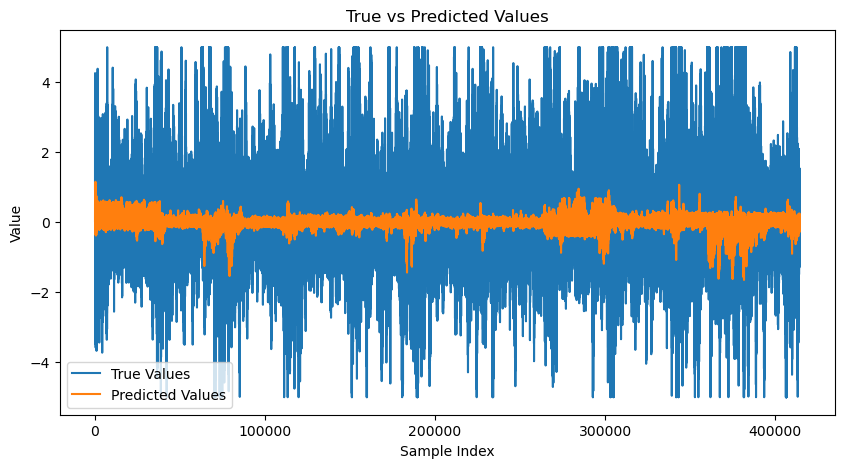

In [124]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(val_set[target_cols].reset_index(drop =True), label='True Values')
plt.plot(pred_inverse, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [125]:
def validate_n_fold(model,val_set,n_folds):
    global all_features_cols, target_cols, weight_cols, ScaleX, ScaleY
    batch_size = len(val_set)//n_folds
    X_val = ScaleX.transform(val_set[all_features_cols])    
    for i in range(0, len(val_set), batch_size):
        X_batch = X_val[i:i+batch_size]
        val_batch = val_set[i:i+batch_size]
        preds = model.predict(X_batch)
        pred_inverse = ScaleY.inverse_transform(preds.reshape(-1, 1))
        score1 = r2_score(val_batch[target_cols], pred_inverse ,sample_weight= val_batch[weight_cols])
        print(f'Batch {i//batch_size} r2_score: {score1:.6f}')

In [126]:
validate_n_fold(model, val_set, 10)

Batch 0 r2_score: 0.002455
Batch 1 r2_score: -0.012048
Batch 2 r2_score: 0.000223
Batch 3 r2_score: 0.006129
Batch 4 r2_score: 0.001274
Batch 5 r2_score: 0.007184
Batch 6 r2_score: -0.000038
Batch 7 r2_score: 0.011647
Batch 8 r2_score: 0.001997
Batch 9 r2_score: -0.002679
Batch 10 r2_score: -4.578206


# test with train data 8

In [127]:
import joblib
# save
joblib.dump(model, "XGBoost.pkl") 
joblib.dump(ScaleY, "XGBoost_scaleY.pkl")

['XGBoost_scaleY.pkl']